In [ ]:
#This script is for getting basic land cover map for a region of interest.
import geemap
import ee
import subprocess  # For installing libraries

Map = geemap.Map()
Map.add_basemap('HYBRID')

Dynamic_World = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
roi = ee.FeatureCollection("projects/ee-clivedcosta/assets/250halot1")
Map.centerObject(roi)
scale = 10

start_date = '2016-02-02'
end_date = '2025-06-01'

images = geemap.dynamic_world_timeseries(
    roi, start_date, end_date, return_type="class"
)

vis_params = {'bands': ['label'], 'palette': [
    '#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', '#DFC35A',
    '#C4281B', '#A59B8F', '#B39FE1'
], 'min': 0, 'max': 8}

first_image = images.first()

def image_to_feature_collection(image, roi, scale):
    features = []
    for i in range(9):
        class_mask = image.eq(i)
        class_vectors = class_mask.reduceToVectors(
            geometry=roi,
            geometryType='centroid',  # or 'polygon'
            scale=scale,
            crs = 'EPSG:4326'
        )
        features.append(class_vectors.filter(ee.Filter.neq('label', None)).map(lambda f: f.set('class', i)))
    return ee.FeatureCollection(features).flatten()

feature_collection = image_to_feature_collection(first_image, roi, scale)


Map.addLayer(images.first(), vis_params, 'First image')
Map.ts_inspector(images, left_vis=vis_params, date_format='YYYY')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Dropdown(layout=Layo…

In [ ]:
#This code is to get real time eligiblity check for any area (last 10 years deforestation plus current forest cover)
# This code exports kml files excluding deforested areas (2016 baseline + current forest cover)
# can exclude the export function for the Ai tool 
import geemap
import ee
from datetime import datetime

# Initialize Earth Engine
ee.Initialize()

Map = geemap.Map()
Map.add_basemap('HYBRID')

Dynamic_World = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
roi = ee.FeatureCollection("projects/ee-clivedcosta/assets/250halot1")
Map.centerObject(roi)
scale = 10

# Define dates - 2016 for baseline and current for real-time assessment
start_date_2016 = '2016-01-01'
end_date_2016 = '2016-12-31'

# Current period (2024-2025)
start_date_current = '2024-01-01'
end_date_current = '2025-12-31'  # Adjust based on available data

# Get Dynamic World classification for 2016 (baseline)
dw_2016 = Dynamic_World.filterBounds(roi) \
    .filterDate(start_date_2016, end_date_2016) \
    .select('label') \
    .mode()

# Get Dynamic World classification for current period
dw_current = Dynamic_World.filterBounds(roi) \
    .filterDate(start_date_current, end_date_current) \
    .select('label') \
    .mode()

# Define NON-ELIGIBLE classes for 2016 baseline (VM0047 criteria)
# Water (0) and Trees (1) are non-eligible in 2016
non_eligible_2016_mask = dw_2016.eq(0).Or(dw_2016.eq(1))

# Define CURRENT forest cover (Trees class = 1)
current_forest_mask = dw_current.eq(1)

# COMBINED ELIGIBILITY CRITERIA:
# Eligible only if:
# 1. Was NOT water/trees in 2016 (VM0047 baseline requirement)
# 2. Is NOT currently forest (real-time forest protection)
eligible_areas_mask = non_eligible_2016_mask.Not().And(current_forest_mask.Not())

# METHOD: Clip eligible areas to original polygons to preserve properties
def clip_eligible_to_polygon(feature):
    geometry = feature.geometry()
    
    # Clip the eligible mask to this specific polygon
    poly_eligible_mask = eligible_areas_mask.clip(geometry)
    
    # Convert eligible areas within this polygon to vectors
    eligible_vectors = poly_eligible_mask.selfMask().reduceToVectors(
        geometry=geometry,
        scale=scale,
        geometryType='polygon',
        crs='EPSG:4326',
        bestEffort=True,
        maxPixels=1e13
    )
    
    # Add original properties to each eligible part
    eligible_with_props = eligible_vectors.map(lambda eligible_feature: 
        eligible_feature.set(feature.toDictionary())
    )
    
    return eligible_with_props

# Apply to all polygons and flatten
all_eligible_parts = roi.map(clip_eligible_to_polygon).flatten()

# Visualization parameters
vis_params_dw = {'bands': ['label'], 'palette': [
    '#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', 
    '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1'
], 'min': 0, 'max': 8}

Map.addLayer(dw_2016.clip(roi), vis_params_dw, '2016 Land Use (Baseline)')
Map.addLayer(dw_current.clip(roi), vis_params_dw, 'Current Land Use (2024-25)')
Map.addLayer(all_eligible_parts, {'color': '00FF00'}, 'Final Eligible Areas')

# Calculate areas
print("=== AREA CALCULATIONS ===")

# Total area
total_area = roi.geometry().area().divide(10000)  # in hectares
total_ha = total_area.getInfo()
print("Total ROI area:", total_ha, "hectares")

# 2016 Non-eligible area (water + trees)
non_eligible_2016_area = non_eligible_2016_mask.multiply(ee.Image.pixelArea()) \
    .reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=roi,
        scale=scale,
        maxPixels=1e13
    ).get('label')

non_eligible_2016_ha = ee.Number(non_eligible_2016_area).divide(10000).getInfo()
print("2016 Non-eligible area (water + trees):", non_eligible_2016_ha, "hectares")

# Current forest area
current_forest_area = current_forest_mask.multiply(ee.Image.pixelArea()) \
    .reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=roi,
        scale=scale,
        maxPixels=1e13
    ).get('label')

current_forest_ha = ee.Number(current_forest_area).divide(10000).getInfo()
print("Current forest area (2024-25):", current_forest_ha, "hectares")

# Final eligible area (excludes 2016 water/trees AND current forests)
final_eligible_area = eligible_areas_mask.multiply(ee.Image.pixelArea()) \
    .reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=roi,
        scale=scale,
        maxPixels=1e13
    ).get('label')

final_eligible_ha = ee.Number(final_eligible_area).divide(10000).getInfo()
print("Final eligible area (excludes 2016 water/trees + current forests):", final_eligible_ha, "hectares")

# Additional analysis: Areas that became forest after 2016
new_forests_mask = non_eligible_2016_mask.Not().And(current_forest_mask)
new_forests_area = new_forests_mask.multiply(ee.Image.pixelArea()) \
    .reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=roi,
        scale=scale,
        maxPixels=1e13
    ).get('label')

new_forests_ha = ee.Number(new_forests_area).divide(10000).getInfo()
print("New forests since 2016 (were eligible but now forest):", new_forests_ha, "hectares")

print("\n=== ELIGIBILITY SUMMARY ===")
print(f"Total area: {total_ha:.2f} hectares")
print(f"Excluded - 2016 water/trees: {non_eligible_2016_ha:.2f} hectares")
print(f"Excluded - Current forests: {current_forest_ha:.2f} hectares")
print(f"Excluded - New forests since 2016: {new_forests_ha:.2f} hectares")
print(f"FINAL ELIGIBLE: {final_eligible_ha:.2f} hectares")

# Export to KML
print("\n=== EXPORTING KML ===")
export_task = ee.batch.Export.table.toDrive(
    collection=all_eligible_parts,
    description='250ha_lot1__eligible_realtime',
    folder='GEE_Exports',
    fileFormat='KML'
)

export_task.start()
print("Export task started. Check Tasks tab in Earth Engine Code Editor for progress.")
print("The exported KML contains areas that:")
print("1. Were NOT water/trees in 2016 (VM0047 baseline)")
print("2. Are NOT currently forest (real-time protection)")

Map.addLayerControl()
Map

=== AREA CALCULATIONS ===
Total ROI area: 30.683131070148647 hectares
2016 Non-eligible area (water + trees): 5.195962101835362 hectares
Current forest area (2024-25): 0.9745088523236444 hectares
Final eligible area (excludes 2016 water/trees + current forests): 25.313903940986183 hectares
New forests since 2016 (were eligible but now forest): 0.07257135467529297 hectares

=== ELIGIBILITY SUMMARY ===
Total area: 30.68 hectares
Excluded - 2016 water/trees: 5.20 hectares
Excluded - Current forests: 0.97 hectares
Excluded - New forests since 2016: 0.07 hectares
FINAL ELIGIBLE: 25.31 hectares

=== EXPORTING KML ===
Export task started. Check Tasks tab in Earth Engine Code Editor for progress.
The exported KML contains areas that:
1. Were NOT water/trees in 2016 (VM0047 baseline)
2. Are NOT currently forest (real-time protection)


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [7]:
# This code is to check the eligibility of the plantation area by excluding the conservation zones from the AOI
# -------------------- Step 1: Import Required Libraries --------------------
# -------------------- Step 1: Import Required Libraries --------------------
import ee
import geopandas as gpd
from shapely.geometry import shape
import folium
from folium import LayerControl
import os

# -------------------- Step 2: Initialize Google Earth Engine --------------------
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

# -------------------- Step 3: Load AOI from Earth Engine (need to put a kml input for this
# ) --------------------
aoi_asset_path = "projects/ee-clivedcosta/assets/2nov"
aoi = ee.FeatureCollection(aoi_asset_path)

# Convert EE FeatureCollection to GeoJSON (client-side)
aoi_geojson = aoi.getInfo()
aoi_gdf = gpd.GeoDataFrame.from_features(aoi_geojson['features'])
aoi_gdf.set_crs(epsg=4326, inplace=True)

# -------------------- Step 4: Load Conservation Zones from Shapefile need to put it on server as it can be located in the local system--------------------
shapefile_path = "C:/Users/ganes/Desktop/Maps/Conservation area/Protected_Area_India_Final.shp"
conservation_gdf = gpd.read_file(shapefile_path)
conservation_gdf = conservation_gdf.to_crs(epsg=4326)  # Match CRS with AOI

# -------------------- Step 5: Fix Invalid Geometries (if any) --------------------
aoi_gdf['geometry'] = aoi_gdf['geometry'].buffer(0)
conservation_gdf['geometry'] = conservation_gdf['geometry'].buffer(0)

# -------------------- Step 6: Check Overlap and Calculate Area --------------------
# Perform intersection to find overlapping regions
intersection = gpd.overlay(aoi_gdf, conservation_gdf, how='intersection')

# Project to UTM for accurate area calculation
utm_crs = aoi_gdf.estimate_utm_crs()
aoi_gdf_utm = aoi_gdf.to_crs(utm_crs)
intersection_utm = intersection.to_crs(utm_crs)

# Calculate areas
aoi_total_area = aoi_gdf_utm['geometry'].area.sum()         # in square meters
overlap_area = intersection_utm['geometry'].area.sum()      # in square meters
eligible_area = aoi_total_area - overlap_area               # in square meters

# -------------------- Step 7: Print the Results --------------------
print("📍 Area Summary (in hectares):")
print(f"Total AOI Area         : {aoi_total_area / 1e4:.2f} ha")
print(f"Overlapping Area       : {overlap_area / 1e4:.2f} ha")
print(f"Eligible Area for Plantation: {eligible_area / 1e4:.2f} ha")

# -------------------- Step 8: Visualize on Satellite Map --------------------
# Center map on AOI centroid
aoi_center = aoi_gdf.geometry.unary_union.centroid
m = folium.Map(location=[aoi_center.y, aoi_center.x], zoom_start=7, tiles='Stamen Terrain')

# Add AOI boundary (Green)
folium.GeoJson(
    aoi_gdf,
    name="AOI (Plantation Zone)",
    style_function=lambda x: {"color": "green", "weight": 2, "fillOpacity": 0.1}
).add_to(m)

# Add Conservation Zones (Red)
folium.GeoJson(
    conservation_gdf,
    name="Conservation Zones",
    style_function=lambda x: {"color": "red", "weight": 1, "fillOpacity": 0.05}
).add_to(m)

# Add Overlapping Area (Orange)
if not intersection.empty:
    folium.GeoJson(
        intersection,
        name="Overlapping Area (Non-eligible)",
        style_function=lambda x: {"color": "orange", "weight": 2, "fillOpacity": 0.3}
    ).add_to(m)

# Add Layer Control
folium.LayerControl().add_to(m)

# Display map
m

# (Optional) Save map to HTML file
# m.save("eligibility_map.html")



📍 Area Summary (in hectares):
Total AOI Area         : 14.72 ha
Overlapping Area       : 0.00 ha
Eligible Area for Plantation: 14.72 ha


In [ ]:
# This code is to check the eligibility of the plantation area by excluding the conservation zones from the AOI and then exporting the eligible area as kml file
# In case the kml falls in consercation zone it will redo the kml export excluding the consercation zone

# -------------------- Step 1: Import Required Libraries --------------------
import ee
import geopandas as gpd
from shapely.geometry import shape
import folium
from folium import LayerControl
import os

# -------------------- Step 2: Initialize Google Earth Engine --------------------
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

# -------------------- Step 3: Load AOI from Google Earth Engine --------------------
aoi_asset_path = "projects/ee-clivedcosta/assets/Chattarpur"
aoi = ee.FeatureCollection(aoi_asset_path)

# Convert EE FeatureCollection to GeoJSON (client-side) and then to GeoDataFrame
aoi_geojson = aoi.getInfo()
aoi_gdf = gpd.GeoDataFrame.from_features(aoi_geojson['features'])
aoi_gdf.set_crs(epsg=4326, inplace=True)

# -------------------- Step 4: Load Conservation Zones from Shapefile --------------------
shapefile_path = "C:/Users/ganes/Desktop/Maps/Conservation area/Protected_Area_India_Final.shp"
conservation_gdf = gpd.read_file(shapefile_path)
conservation_gdf = conservation_gdf.to_crs(epsg=4326)

# -------------------- Step 5: Fix Invalid Geometries --------------------
aoi_gdf['geometry'] = aoi_gdf['geometry'].buffer(0)
conservation_gdf['geometry'] = conservation_gdf['geometry'].buffer(0)

# -------------------- Step 6: Calculate Intersection and Difference --------------------
# Find overlapping area
intersection = gpd.overlay(aoi_gdf, conservation_gdf, how='intersection')

# Subtract conservation zones to get eligible area
eligible_gdf = gpd.overlay(aoi_gdf, conservation_gdf, how='difference')

# Project to UTM for area calculation
utm_crs = aoi_gdf.estimate_utm_crs()
aoi_gdf_utm = aoi_gdf.to_crs(utm_crs)
intersection_utm = intersection.to_crs(utm_crs)
eligible_gdf_utm = eligible_gdf.to_crs(utm_crs)

# -------------------- Step 7: Calculate Areas --------------------
aoi_total_area = aoi_gdf_utm['geometry'].area.sum()
overlap_area = intersection_utm['geometry'].area.sum()
eligible_area = eligible_gdf_utm['geometry'].area.sum()

print("📍 Area Summary (in hectares):")
print(f"Total AOI Area         : {aoi_total_area / 1e4:.2f} ha")
print(f"Overlapping Area       : {overlap_area / 1e4:.2f} ha")
print(f"Eligible Area for Plantation: {eligible_area / 1e4:.2f} ha")

# -------------------- Step 8: Save Eligible Area as KML --------------------
output_kml_path = "eligible_area.kml"
eligible_gdf.to_file(output_kml_path, driver='KML')
print(f"✅ KML saved to: {os.path.abspath(output_kml_path)}")

# -------------------- Step 9: Visualize on Map --------------------
aoi_center = aoi_gdf.geometry.unary_union.centroid
m = folium.Map(location=[aoi_center.y, aoi_center.x], zoom_start=7, tiles='Stamen Terrain')

folium.GeoJson(
    aoi_gdf,
    name="AOI (Plantation Zone)",
    style_function=lambda x: {"color": "green", "weight": 2, "fillOpacity": 0.1}
).add_to(m)

folium.GeoJson(
    conservation_gdf,
    name="Conservation Zones",
    style_function=lambda x: {"color": "red", "weight": 1, "fillOpacity": 0.05}
).add_to(m)

if not intersection.empty:
    folium.GeoJson(
        intersection,
        name="Overlapping Area (Non-eligible)",
        style_function=lambda x: {"color": "orange", "weight": 2, "fillOpacity": 0.3}
    ).add_to(m)

if not eligible_gdf.empty:
    folium.GeoJson(
        eligible_gdf,
        name="Eligible Area (Plantation Possible)",
        style_function=lambda x: {"color": "blue", "weight": 2, "fillOpacity": 0.2}
    ).add_to(m)

folium.LayerControl().add_to(m)

# -------------------- Step 10: Display or Save Map --------------------
m.save("eligibility_map.html")
print("🗺️ Map saved to: eligibility_map.html")

# -------------------- Step 11: (Optional) Start Local Server for Download --------------------
# Run this part only if you want to serve the file on localhost
# from http.server import SimpleHTTPRequestHandler, HTTPServer
# import webbrowser

# port = 8000
# os.chdir(os.path.dirname(output_kml_path))
# webbrowser.open(f"http://localhost:{port}/{os.path.basename(output_kml_path)}")
# print(f"🔗 Download link: http://localhost:{port}/{os.path.basename(output_kml_path)}")
# HTTPServer(("", port), SimpleHTTPRequestHandler).serve_forever()


📍 Area Summary (in hectares):
Total AOI Area         : 867211.22 ha
Overlapping Area       : 20972.91 ha
Eligible Area for Plantation: 846238.31 ha
✅ KML saved to: c:\Users\ganes\Documents\Gis-prog\.ipynb_checkpoints\eligible_area.kml
🗺️ Map saved to: eligibility_map.html


In [23]:

#This code is just the calculate the area in Hectares from a KML file

# -------------------- Step 1: Import Required Libraries --------------------
import geopandas as gpd

# -------------------- Step 2: Load KML File from Local Path --------------------
# Replace this with the path to your KML file
kml_path = r"C:\Users\ganes\Desktop\Navchetna\Oct 31\1200ha.kml"


# Read the KML file (use the 'layer=0' option for default KML reading)
gdf = gpd.read_file(kml_path, driver='KML')

# -------------------- Step 3: Fix Geometry and CRS --------------------
# Ensure CRS is WGS84
gdf = gdf.set_crs(epsg=4326)

# Remove invalid geometries if any
gdf['geometry'] = gdf['geometry'].buffer(0)

# -------------------- Step 4: Project to UTM for Accurate Area Calculation --------------------
utm_crs = gdf.estimate_utm_crs()
gdf_utm = gdf.to_crs(utm_crs)

# -------------------- Step 5: Calculate and Print Area --------------------
# Area in square meters, then convert to hectares
total_area_sq_m = gdf_utm['geometry'].area.sum()
total_area_ha = total_area_sq_m / 1e4

print("📍 Area Calculation from KML:")
print(f"Total Area: {total_area_ha:.2f} hectares")


📍 Area Calculation from KML:
Total Area: 1268.93 hectares


Successfully loaded KML with 2 polygon(s)

Processing polygon 1-1...
2D Horizontal Area: 201.77 hectares
Generated 221 sample points within polygon
Fetching elevation data...
Valid elevation points: 221/221
3D Surface Area: 210.93 hectares
Area Ratio (3D/2D): 1.05

Processing polygon 2-1...
2D Horizontal Area: 190.53 hectares
Generated 236 sample points within polygon
Fetching elevation data...
Valid elevation points: 236/236
3D Surface Area: 198.39 hectares
Area Ratio (3D/2D): 1.04

SUMMARY RESULTS
Total 2D Area: 392.29 hectares
Total 3D Surface Area: 409.32 hectares
Overall 3D/2D Ratio: 1.04


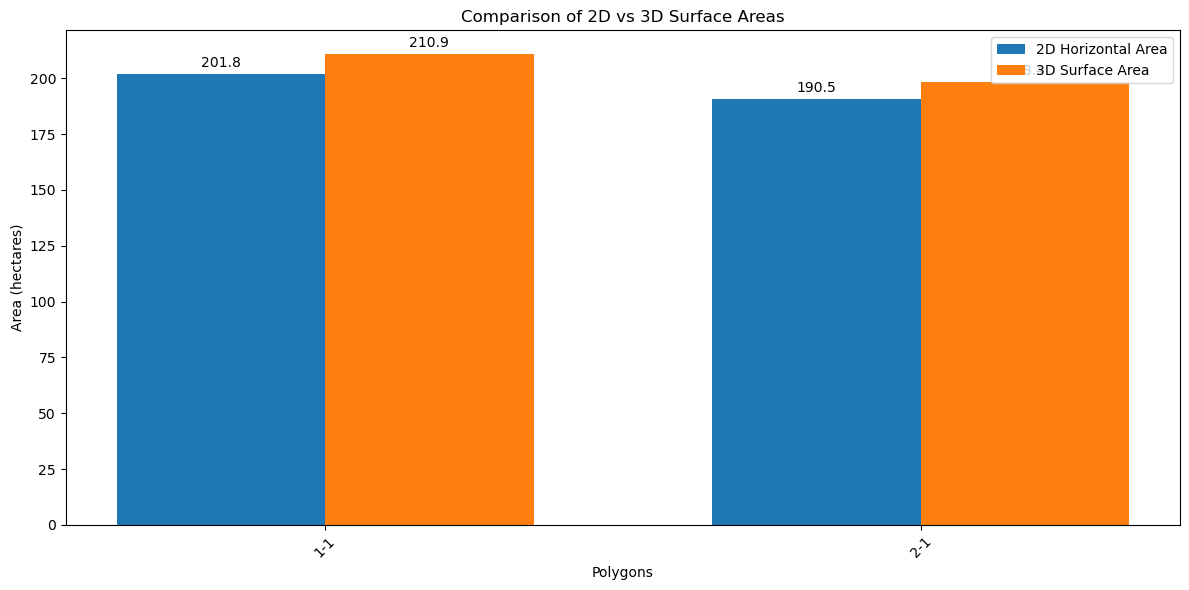

In [15]:
#This code is to calculate the surface area of polygons in a KML file considering elevation data from online APIs
import geopandas as gpd
import numpy as np
import requests
import time
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
from pyproj import CRS, Transformer
import json

class KMLSurfaceAreaCalculator:
    def __init__(self):
        self.elevation_api_urls = {
            'open_elevation': 'https://api.open-elevation.com/api/v1/lookup',
            'elevation_api': 'https://elevation-api.io/api/elevation',
            'open_topo': 'https://api.opentopodata.org/v1/aster30m'  # Requires specific datasets
        }
        
    def read_kml_file(self, kml_path):
        """Read KML file and return GeoDataFrame"""
        try:
            gdf = gpd.read_file(kml_path)
            print(f"Successfully loaded KML with {len(gdf)} polygon(s)")
            return gdf
        except Exception as e:
            print(f"Error reading KML: {e}")
            return None
    
    def get_elevation_batch(self, points, api_source='open_elevation'):
        """Get elevation for multiple points using batch API calls"""
        elevations = []
        
        if api_source == 'open_elevation':
            # Prepare locations for batch request
            locations = [{"latitude": lat, "longitude": lon} for lat, lon in points]
            
            # Split into batches of 100 (API limit)
            batch_size = 100
            for i in range(0, len(locations), batch_size):
                batch = locations[i:i + batch_size]
                payload = {"locations": batch}
                
                try:
                    response = requests.post(
                        self.elevation_api_urls[api_source],
                        json=payload,
                        headers={'Content-Type': 'application/json'},
                        timeout=30
                    )
                    
                    if response.status_code == 200:
                        data = response.json()
                        batch_elevations = [result['elevation'] for result in data['results']]
                        elevations.extend(batch_elevations)
                    else:
                        print(f"API error: {response.status_code}")
                        # Fill with zeros for failed batch
                        elevations.extend([0] * len(batch))
                        
                except Exception as e:
                    print(f"Request failed: {e}")
                    elevations.extend([0] * len(batch))
                
                # Be nice to the API
                time.sleep(0.5)
                
        return elevations
    
    def sample_points_in_polygon(self, polygon, samples_per_dimension=20):
        """Generate sample points within polygon for elevation sampling"""
        bounds = polygon.bounds
        min_x, min_y, max_x, max_y = bounds
        
        points = []
        sample_lats = np.linspace(min_y, max_y, samples_per_dimension)
        sample_lons = np.linspace(min_x, max_x, samples_per_dimension)
        
        for lat in sample_lats:
            for lon in sample_lons:
                point = Point(lon, lat)
                if polygon.contains(point):
                    points.append((lat, lon))
        
        print(f"Generated {len(points)} sample points within polygon")
        return points
    
    def calculate_surface_area_triangulation(self, points_3d):
        """Calculate surface area using 3D triangulation"""
        from scipy.spatial import Delaunay
        
        if len(points_3d) < 3:
            return 0
            
        # Convert to numpy array
        points_array = np.array(points_3d)
        
        # Perform 2D Delaunay triangulation on x,y coordinates
        tri = Delaunay(points_array[:, :2])
        
        total_area = 0
        for simplex in tri.simplices:
            # Get the three points of the triangle
            A, B, C = points_array[simplex]
            
            # Calculate area of 3D triangle using cross product method
            AB = B - A
            AC = C - A
            cross_product = np.cross(AB, AC)
            triangle_area = 0.5 * np.linalg.norm(cross_product)
            total_area += triangle_area
        
        return total_area
    
    def calculate_2d_area(self, polygon):
        """Calculate 2D planar area in hectares"""
        # Convert to UTM for accurate area calculation
        centroid = polygon.centroid
        utm_zone = int((centroid.x + 180) / 6) + 1
        hemisphere = 'north' if centroid.y >= 0 else 'south'
        epsg_code = 32600 + utm_zone if hemisphere == 'north' else 32700 + utm_zone
        
        try:
            transformer = Transformer.from_crs('EPSG:4326', f'EPSG:{epsg_code}', always_xy=True)
            poly_utm = Polygon([transformer.transform(x, y) for x, y in polygon.exterior.coords])
            area_sq_m = poly_utm.area
            area_hectares = area_sq_m / 10000
            return area_hectares
        except:
            # Fallback to approximate calculation
            return polygon.area * 111319.488 * 111319.488 / 10000  # Rough conversion
    
    def calculate_surface_area(self, kml_path, samples_per_dimension=15, api_source='open_elevation'):
        """Main function to calculate surface area with elevation data"""
        
        # Read KML file
        gdf = self.read_kml_file(kml_path)
        if gdf is None:
            return None
        
        results = []
        
        for idx, row in gdf.iterrows():
            polygon = row.geometry
            
            if polygon.geom_type not in ['Polygon', 'MultiPolygon']:
                print(f"Skipping non-polygon geometry: {polygon.geom_type}")
                continue
            
            # Handle MultiPolygon by processing each polygon separately
            if polygon.geom_type == 'MultiPolygon':
                polygons = list(polygon.geoms)
            else:
                polygons = [polygon]
            
            for poly_idx, poly in enumerate(polygons):
                print(f"\nProcessing polygon {idx+1}-{poly_idx+1}...")
                
                # Calculate 2D area
                area_2d_ha = self.calculate_2d_area(poly)
                print(f"2D Horizontal Area: {area_2d_ha:.2f} hectares")
                
                # Sample points within polygon
                points_2d = self.sample_points_in_polygon(poly, samples_per_dimension)
                
                if len(points_2d) < 3:
                    print("Not enough points for surface area calculation")
                    results.append({
                        'polygon': f"{idx+1}-{poly_idx+1}",
                        'area_2d_ha': area_2d_ha,
                        'area_3d_ha': area_2d_ha,
                        'ratio': 1.0,
                        'points_sampled': len(points_2d),
                        'status': 'insufficient_points'
                    })
                    continue
                
                # Get elevations for sampled points
                print("Fetching elevation data...")
                elevations = self.get_elevation_batch(points_2d, api_source)
                
                # Convert to 3D points (lat, lon, elevation)
                points_3d = []
                valid_points = 0
                for (lat, lon), elev in zip(points_2d, elevations):
                    if elev > -100:  # Filter out invalid elevations (ocean depths, errors)
                        # Convert to meters in local tangent plane (approximate)
                        # This is a simplification but works for small areas
                        x = lon * 111319.488  # meters per degree longitude (at equator)
                        y = lat * 111319.488  # meters per degree latitude
                        points_3d.append([x, y, elev])
                        valid_points += 1
                
                print(f"Valid elevation points: {valid_points}/{len(points_2d)}")
                
                if valid_points < 3:
                    print("Not enough valid elevation data")
                    results.append({
                        'polygon': f"{idx+1}-{poly_idx+1}",
                        'area_2d_ha': area_2d_ha,
                        'area_3d_ha': area_2d_ha,
                        'ratio': 1.0,
                        'points_sampled': valid_points,
                        'status': 'insufficient_elevation_data'
                    })
                    continue
                
                # Calculate 3D surface area
                area_3d_sq_m = self.calculate_surface_area_triangulation(points_3d)
                area_3d_ha = area_3d_sq_m / 10000
                
                ratio = area_3d_ha / area_2d_ha if area_2d_ha > 0 else 1.0
                
                print(f"3D Surface Area: {area_3d_ha:.2f} hectares")
                print(f"Area Ratio (3D/2D): {ratio:.2f}")
                
                results.append({
                    'polygon': f"{idx+1}-{poly_idx+1}",
                    'area_2d_ha': area_2d_ha,
                    'area_3d_ha': area_3d_ha,
                    'ratio': ratio,
                    'points_sampled': valid_points,
                    'status': 'success'
                })
        
        return results
    
    def plot_results(self, results):
        """Plot comparison between 2D and 3D areas"""
        if not results:
            return
            
        polygons = [r['polygon'] for r in results]
        areas_2d = [r['area_2d_ha'] for r in results]
        areas_3d = [r['area_3d_ha'] for r in results]
        
        x = np.arange(len(polygons))
        width = 0.35
        
        fig, ax = plt.subplots(figsize=(12, 6))
        bars1 = ax.bar(x - width/2, areas_2d, width, label='2D Horizontal Area')
        bars2 = ax.bar(x + width/2, areas_3d, width, label='3D Surface Area')
        
        ax.set_xlabel('Polygons')
        ax.set_ylabel('Area (hectares)')
        ax.set_title('Comparison of 2D vs 3D Surface Areas')
        ax.set_xticks(x)
        ax.set_xticklabels(polygons)
        ax.legend()
        
        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.annotate(f'{height:.1f}',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3),
                           textcoords="offset points",
                           ha='center', va='bottom')
        
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Usage Example
def main():
    calculator = KMLSurfaceAreaCalculator()
    
    # Calculate surface area for your KML file
    kml_file_path = r"C:\Users\ganes\Desktop\Uttrakhandpoly\Nanital revised.kml" # Replace with your KML file path
    
    results = calculator.calculate_surface_area(
        kml_file_path, 
        samples_per_dimension=20,  # More samples = more accuracy but slower
        api_source='open_elevation'
    )
    
    # Print summary
    if results:
        print("\n" + "="*50)
        print("SUMMARY RESULTS")
        print("="*50)
        
        total_2d = sum(r['area_2d_ha'] for r in results)
        total_3d = sum(r['area_3d_ha'] for r in results)
        overall_ratio = total_3d / total_2d if total_2d > 0 else 1.0
        
        print(f"Total 2D Area: {total_2d:.2f} hectares")
        print(f"Total 3D Surface Area: {total_3d:.2f} hectares")
        print(f"Overall 3D/2D Ratio: {overall_ratio:.2f}")
        
        # Plot results
        calculator.plot_results(results)
    
    return results

# Run the analysis
if __name__ == "__main__":
    results = main()